In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from HenonHeiles import *
from NeuralNetworks import *
from numerical_integration import *
from Training import *

torch.random.manual_seed(1)
np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [9]:
def initial_condition(lam = 1):
    def sampler():
            """Function for sampling initial conditions. Callabale taking
                a numpy random generator as input and returning an ndarray
                of shape (nstates,) with inital conditions for the system."""
        
            x0= 0
            H0 = np.random.uniform(0,1/10)
            while True:
                y0 = np.random.uniform(-1,1)    
                py0 = np.random.uniform(-1,1)
                K = 2*H0-(py0**2 +y0**2-lam/3*y0**3)
                if K>= 0:
                    break
            px0 = np.sqrt(K)

            return np.array([x0,y0,px0,py0]).flatten()
    return sampler()

In [10]:
T_max_train = 5
nsamples_train = 100
ntraj_train = 1750
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 750
epochs = 50

#Activations nn.Tanh(), nn.ReLU(), Sin(), nn.Softplus(), PAU(), PadeTypeActivation

act_1 = Sin()
act_2 = nn.ReLU()

lr = 1e-3
sys = HenonHeilesSystem()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

## Explicit Midpoint

100%|██████████| 50/50 [06:28<00:00,  7.78s/it, epoch=49, loss=1.21e-6]


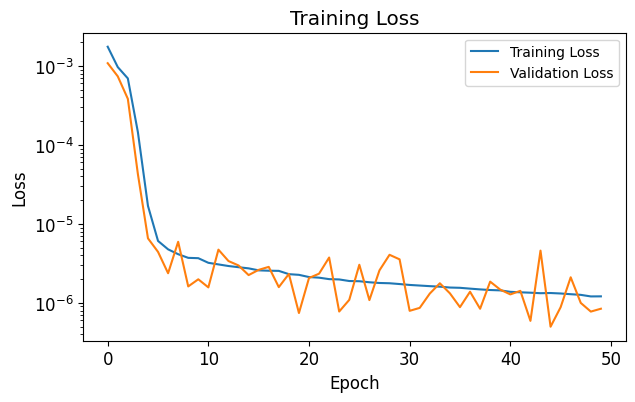

In [82]:
integrator = "midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt
model_exp = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)


optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=lr)
model_exp, trainingdetails_explicit = train(model = model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp,shuffle=True, epochs = epochs)


### Predicting from Explicit Midpoint

100%|██████████| 1/1 [00:00<00:00, 58.97it/s]
/Users/sannejamila/Documents/Vår 2025/HenonHeiles/HamiltonianNeuralNetwork_HenonHeiles/NeuralNetworks.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)


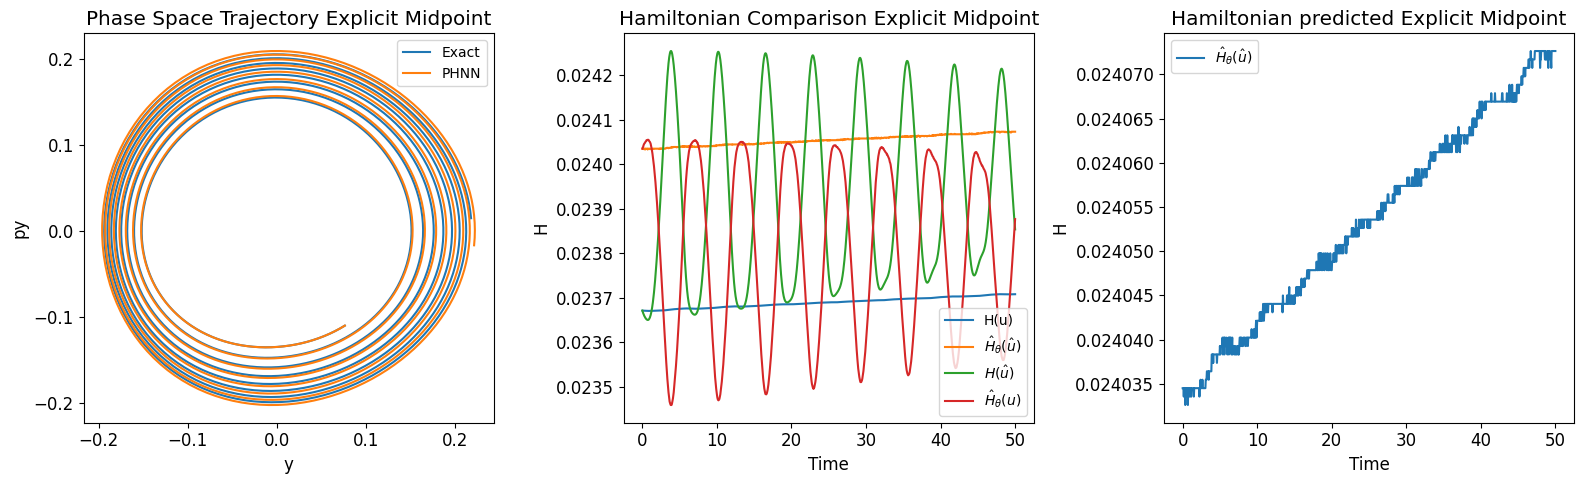

In [83]:
tmax = 50
nsamples = 1000
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
ntrajectories = 1
integrator = "midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)
u_exact = u_exact.squeeze(0)

u_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[:, 1], u_exact[:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_exp[0][:, 1], u_phnn_exp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Explicit Midpoint")
ax[0].legend()


H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact])
t = t_sample.squeeze(0)
u_samples = u_phnn_exp.squeeze(0)

# Computed estimated Hamiltonian from values for prediction
H_exp_nn = torch.tensor([(model_exp.Hamiltonian(u) - model_exp.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_samples])

# Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])

#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_exp.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model_exp.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact])


ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_exp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Explicit Midpoint")
ax[1].legend()


ax[2].plot(t, H_exp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Explicit Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()

## Symplectic Euler

100%|██████████| 50/50 [09:04<00:00, 10.89s/it, epoch=49, loss=8.82e-7]


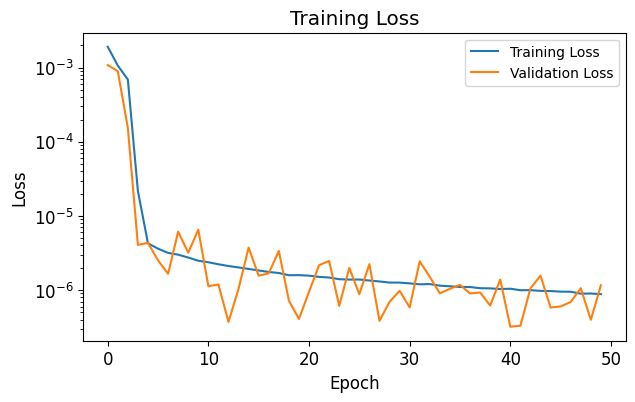

In [84]:
integrator = "symplectic euler"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train, integrator=integrator, u0s=u0s_train)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val, integrator=integrator,  u0s=u0s_val)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

model_symp_eul = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp_eul = torch.optim.Adam(model_symp_eul.parameters(), lr=lr)
model_symp_eul, trainingdetails_symp_eul = train(model = model_symp_eul,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp_eul,shuffle=True, epochs = epochs)


### Predicting from Symplectic Euler

100%|██████████| 1/1 [00:00<00:00, 53.83it/s]


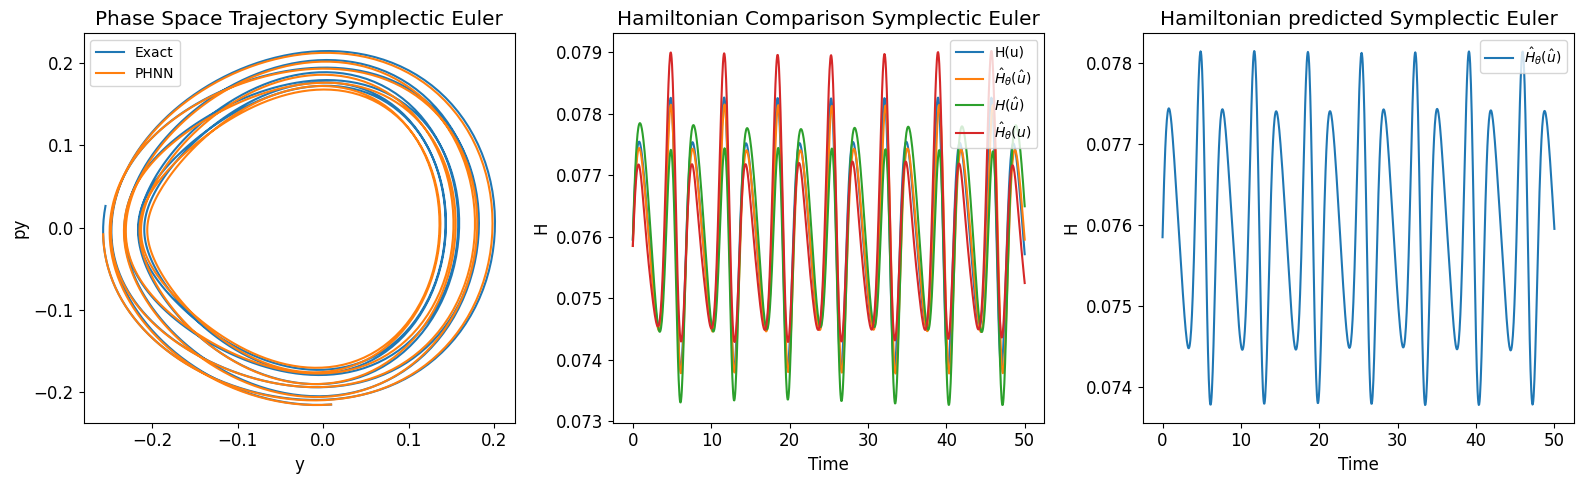

In [85]:
tmax = 50
nsamples = 1000
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic euler"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp_eul.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Euler" )
ax[0].legend()


H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])

t = t_sample.squeeze(0)
u_samples = u_phnn_symp.squeeze(0)
#Computed estimated Hamiltonian from values for prediction
H_symp_nn= torch.tensor([(model_symp_eul.Hamiltonian(u)- model_symp_eul.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])
#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp_eul.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model_symp_eul.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact.squeeze(0)])


ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Euler")
ax[1].legend()

ax[2].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Euler")
ax[2].legend()

plt.tight_layout() 
plt.show()

## Symplectic Midpoint

100%|██████████| 50/50 [04:06<00:00,  4.93s/it, epoch=49, loss=1e-6]   


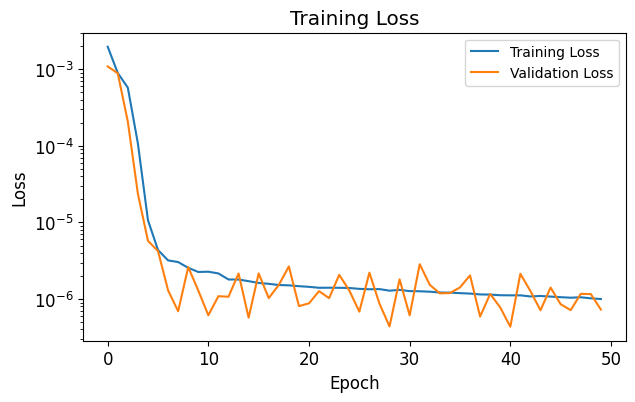

In [86]:
integrator = "symplectic midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train, integrator=integrator, u0s=u0s_train)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val, integrator=integrator,  u0s=u0s_val)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

model_symp = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp = torch.optim.Adam(model_symp.parameters(), lr=lr)
model_symp, trainingdetails_symp = train(model = model_symp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp,shuffle=True, epochs = epochs)


### Predicting from Symplectic Midpoint

100%|██████████| 1/1 [00:00<00:00,  8.14it/s]
/Users/sannejamila/Documents/Vår 2025/HenonHeiles/HamiltonianNeuralNetwork_HenonHeiles/numerical_integration.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


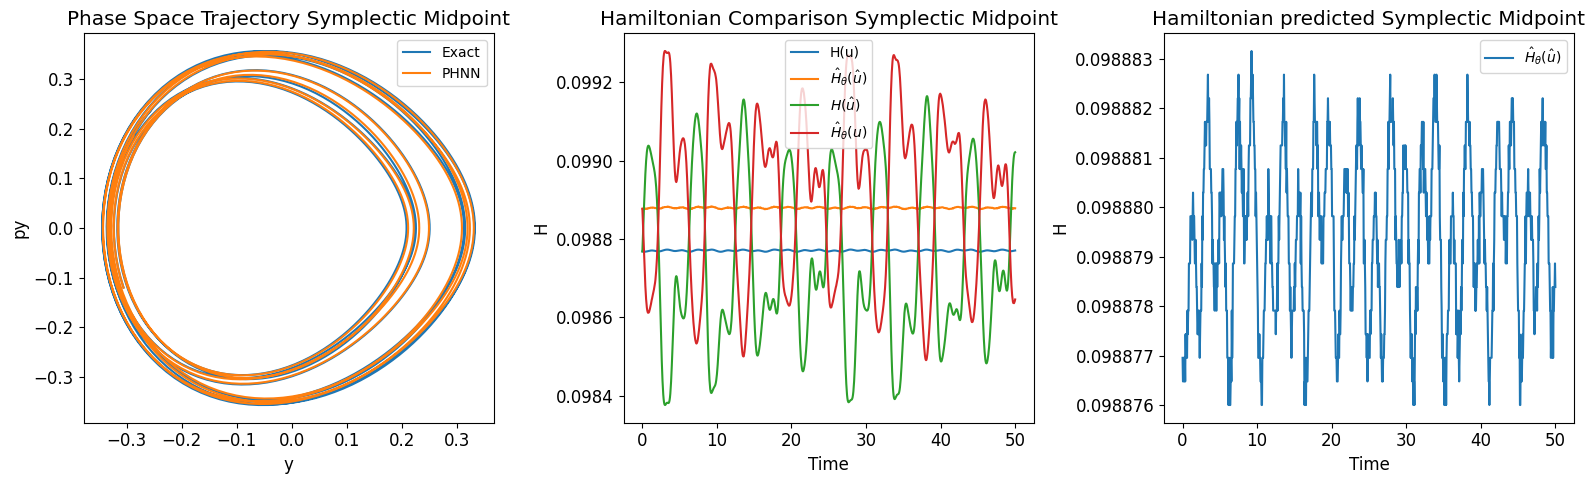

In [87]:
tmax = 50
nsamples = 1000
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory Symplectic Midpoint")
ax[0].legend()


H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])
t = t_sample.squeeze(0)
u_samples = u_phnn_symp.squeeze(0)
#Computed estimated Hamiltonian from values for prediction
H_symp_nn= torch.tensor([(model_symp.Hamiltonian(u)- model_symp.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])

#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model_symp.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact.squeeze(0)])


ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred,  label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison Symplectic Midpoint")
ax[1].legend()



ax[2].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Hamiltonian predicted Symplectic Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()

## Comparing activation functions

### Loading Saved Models

In [22]:
def load_model(path):
    checkpoint = torch.load(path)
    model = checkpoint['model'] 
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, epoch, loss

In [90]:
model_symp_PAU_Soft, epoch, loss_symp_PAU_Soft = load_model("Models/symplectic midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0).pt")
model_symp_Sin_Soft, epoch, loss_symp_Sin_Soft = load_model("Models/symplectic midpoint_50epoch_Sin()_Softplus(beta=1.0, threshold=20.0).pt")
model_symp_Tanh_ReLU, epoch, loss_symp_Tanh_ReLU= load_model("Models/symplectic midpoint_50epoch_Tanh()_ReLU().pt")
model_symp_PAU_ReLU, epoch, loss_symp_PAU_ReLU= load_model("Models/symplectic midpoint_50epoch_PAU()_ReLU().pt")
model_symp_Tanh_soft, epoch, loss_symp_Tanh_soft= load_model("Models/symplectic midpoint_50epoch_Tanh()_Softplus(beta=1.0, threshold=20.0).pt")
model_symp_Sin_ReLU, epoch, loss_symp_Sin_ReLU = load_model("Models/symplectic midpoint_50epoch_Sin()_ReLU().pt")


model_exp_PAU_Soft, epoch, loss_exp_PAU_Soft = load_model("Models/midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0).pt")
model_exp_Sin_Soft, epoch, loss_exp_Sin_Soft = load_model("Models/midpoint_50epoch_Sin()_Softplus(beta=1.0, threshold=20.0).pt")
model_exp_Tanh_ReLU, epoch, loss_exp_Tanh_ReLU= load_model("Models/midpoint_50epoch_Tanh()_ReLU().pt")
model_exp_PAU_ReLU, epoch, loss_exp_PAU_ReLU = load_model("Models/midpoint_50epoch_PAU()_ReLU().pt")
model_exp_Tanh_soft, epoch, loss_exp_Tanh_soft= load_model("Models/midpoint_50epoch_Tanh()_Softplus(beta=1.0, threshold=20.0).pt")
model_exp_Sin_ReLU, epoch, loss_exp_Sin_ReLU = load_model("Models/midpoint_50epoch_Sin()_ReLU().pt")

model_symp_eul_PAU_Soft, epoch, loss_symp_eul_PAU_Soft = load_model("Models/symplectic euler_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0).pt")
model_symp_eul_Sin_Soft, epoch, loss_symp_eul_Sin_Soft = load_model("Models/symplectic euler_50epoch_Sin()_Softplus(beta=1.0, threshold=20.0).pt")
model_symp_eul_Tanh_ReLU, epoch, loss_symp_eul_Tanh_ReLU= load_model("Models/symplectic euler_50epoch_Tanh()_ReLU().pt")
model_symp_eul_PAU_ReLU, epoch, loss_symp_eul_PAU_ReLU= load_model("Models/symplectic euler_50epoch_PAU()_ReLU().pt")
model_symp_eul_Tanh_soft, epoch, loss_symp_eul_Tanh_soft= load_model("Models/symplectic euler_50epoch_Tanh()_Softplus(beta=1.0, threshold=20.0).pt")
model_symp_eul_Sin_ReLU, epoch, loss_symp_eul_Sin_ReLU = load_model("Models/symplectic euler_50epoch_Sin()_ReLU().pt")

/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_42085/3443061592.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


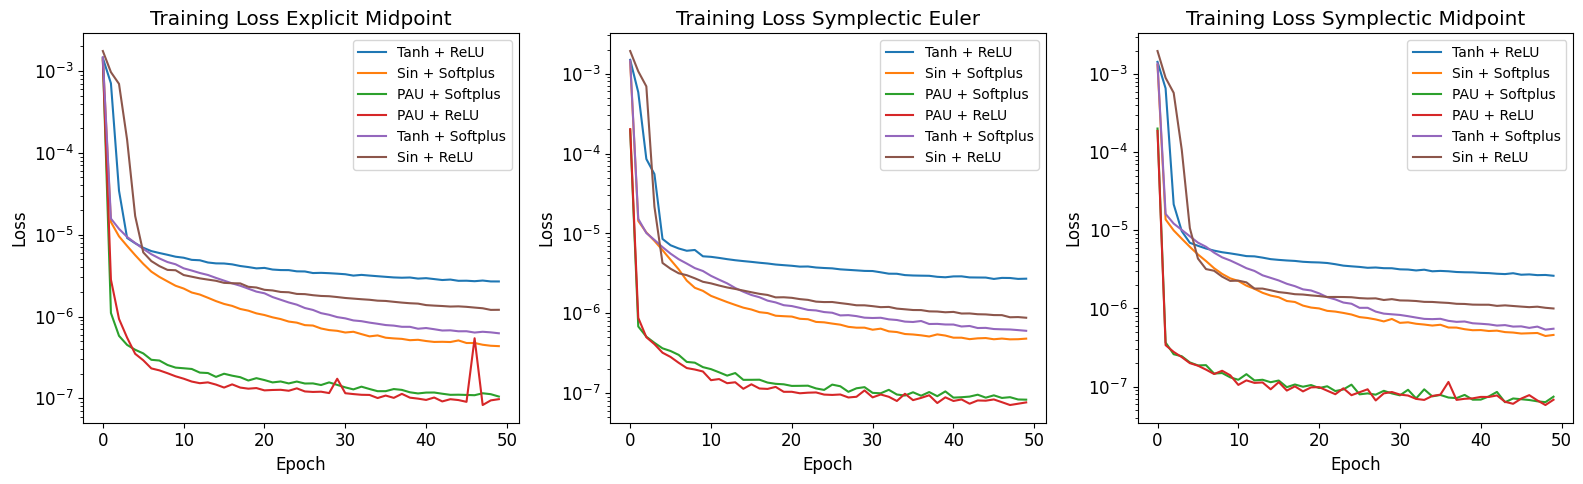

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  

ax[0].plot(loss_exp_Tanh_ReLU, label = "Tanh + ReLU")
ax[0].plot(loss_exp_Sin_Soft, label = "Sin + Softplus")
ax[0].plot(loss_exp_PAU_Soft, label = "PAU + Softplus")
ax[0].plot(loss_exp_PAU_ReLU, label = "PAU + ReLU")
ax[0].plot(loss_exp_Tanh_soft, label = "Tanh + Softplus")
ax[0].plot(loss_exp_Sin_ReLU, label = "Sin + ReLU")
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss Explicit Midpoint')


ax[1].plot(loss_symp_eul_Tanh_ReLU, label = "Tanh + ReLU")
ax[1].plot(loss_symp_eul_Sin_Soft, label = "Sin + Softplus")
ax[1].plot(loss_symp_eul_PAU_Soft, label = "PAU + Softplus")
ax[1].plot(loss_symp_eul_PAU_ReLU, label = "PAU + ReLU")
ax[1].plot(loss_symp_eul_Tanh_soft, label = "Tanh + Softplus")
ax[1].plot(loss_symp_eul_Sin_ReLU, label = "Sin + ReLU")
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training Loss Symplectic Euler')

ax[2].plot(loss_symp_Tanh_ReLU, label = "Tanh + ReLU")
ax[2].plot(loss_symp_Sin_Soft, label = "Sin + Softplus")
ax[2].plot(loss_symp_PAU_Soft, label = "PAU + Softplus")
ax[2].plot(loss_symp_PAU_ReLU, label = "PAU + ReLU")
ax[2].plot(loss_symp_Tanh_soft, label = "Tanh + Softplus")
ax[2].plot(loss_symp_Sin_ReLU, label = "Sin + ReLU")
ax[2].legend()
ax[2].set_yscale('log')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Training Loss Symplectic Midpoint')



plt.tight_layout() 
plt.show()

### Test loss comparison

In [44]:
T_max_test = 5
nsamples_test = 100
ntraj_test = 100

dt_test = T_max_test/nsamples_test
nt_test = round(T_max_test / dt_test)
t_test = np.linspace(0, T_max_test, nt_test + 1)

sys = HenonHeilesSystem()

seed = 949

In [45]:
(u_start, u_end, t_start, t_end, dt, x), dudt, u_test_exp,t, H0, u0_test = generate_data(ntrajectories = ntraj_test, t_sample = t_test,system= sys,integrator = "midpoint")
(u_start, u_end, t_start, t_end, dt, x), dudt, u_test_eul,t, H0, u0_test = generate_data(ntrajectories = ntraj_test, t_sample = t_test,system= sys,integrator = "symplectic euler", u0s = u0_test)
(u_start, u_end, t_start, t_end, dt, x), dudt, u_test_symp,t, H0, u0_test = generate_data(ntrajectories = ntraj_test, t_sample = t_test,system= sys,integrator = "symplectic midpoint",u0s = u0_test)

100%|██████████| 100/100 [00:01<00:00, 70.16it/s]


In [47]:

u_exp_PAU_Soft, _ = model_exp_PAU_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_Sin_Soft, _ = model_exp_Sin_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_Tanh_ReLU, _ = model_exp_Tanh_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_PAU_ReLU, _ = model_exp_PAU_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_Tanh_soft, _ = model_exp_Tanh_soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
u_exp_Sin_ReLU, _ = model_exp_Sin_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)


u_symp_eul_PAU_Soft, _ = model_symp_eul_PAU_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
u_symp_eul_Sin_Soft, _ = model_symp_eul_Sin_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
u_symp_eul_Tanh_ReLU, _ = model_symp_eul_Tanh_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
u_symp_eul_PAU_ReLU, _ = model_symp_eul_PAU_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
u_symp_eul_Tanh_soft, _ = model_symp_eul_Tanh_soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
u_symp_eul_Sin_ReLU, _ = model_symp_eul_Sin_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)


u_symp_PAU_Soft, _ = model_symp_PAU_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_Sin_Soft, _ = model_symp_Sin_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_Tanh_ReLU, _ = model_symp_Tanh_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_PAU_ReLU, _ = model_symp_PAU_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_Tanh_soft, _ = model_symp_Tanh_soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
u_symp_Sin_ReLU, _ = model_symp_Sin_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)



/Users/sannejamila/Documents/Vår 2025/HenonHeiles/HamiltonianNeuralNetwork_HenonHeiles/numerical_integration.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


In [81]:


def test_loss(pred,exact):
    return ((pred-exact)**2).mean()

In [56]:

err_exp_PAU_Soft = []
err_exp_Sin_Soft = [] 
err_exp_Tanh_ReLU = []
err_exp_PAU_ReLU = []
err_exp_Tanh_soft = []
err_exp_Sin_ReLU = []

err_symp_eul_PAU_Soft = [] 
err_symp_eul_Sin_Soft = []
err_symp_eul_Tanh_ReLU = []
err_symp_eul_PAU_ReLU = []
err_symp_eul_Tanh_soft = []
err_symp_eul_Sin_ReLU = []

err_symp_PAU_Soft = [] 
err_symp_Sin_Soft = []
err_symp_Tanh_ReLU = []
err_symp_PAU_ReLU = []
err_symp_Tanh_soft = []
err_symp_Sin_ReLU = []


In [57]:
for i in range(u_symp_Sin_ReLU.shape[0]):
    
    err_exp_PAU_Soft.append(test_loss(u_exp_PAU_Soft[i],u_test_exp[i]))
    err_exp_Sin_Soft.append(test_loss(u_exp_Sin_Soft[i],u_test_exp[i]))
    err_exp_Tanh_ReLU.append(test_loss(u_exp_Tanh_ReLU[i],u_test_exp[i]))
    err_exp_PAU_ReLU.append(test_loss(u_exp_PAU_ReLU[i],u_test_exp[i]))
    err_exp_Tanh_soft.append(test_loss(u_exp_Tanh_soft[i],u_test_exp[i]))
    err_exp_Sin_ReLU.append(test_loss(u_exp_Sin_ReLU[i],u_test_exp[i]))

    err_symp_PAU_Soft.append(test_loss(u_symp_PAU_Soft[i],u_test_symp[i]))
    err_symp_Sin_Soft.append(test_loss(u_symp_Sin_Soft[i],u_test_symp[i]))
    err_symp_Tanh_ReLU.append(test_loss(u_symp_Tanh_ReLU[i],u_test_symp[i]))
    err_symp_PAU_ReLU.append(test_loss(u_symp_PAU_ReLU[i],u_test_symp[i]))
    err_symp_Tanh_soft.append(test_loss(u_symp_Tanh_soft[i],u_test_symp[i]))
    err_symp_Sin_ReLU.append(test_loss(u_symp_Sin_ReLU[i],u_test_symp[i]))

    err_symp_eul_PAU_Soft.append(test_loss(u_symp_eul_PAU_Soft[i],u_test_eul[i]))
    err_symp_eul_Sin_Soft.append(test_loss(u_symp_eul_Sin_Soft[i],u_test_eul[i]))
    err_symp_eul_Tanh_ReLU.append(test_loss(u_symp_eul_Tanh_ReLU[i],u_test_eul[i]))
    err_symp_eul_PAU_ReLU.append(test_loss(u_symp_eul_PAU_ReLU[i],u_test_eul[i]))
    err_symp_eul_Tanh_soft.append(test_loss(u_symp_eul_Tanh_soft[i],u_test_eul[i]))
    err_symp_eul_Sin_ReLU.append(test_loss(u_symp_eul_Sin_ReLU[i],u_test_eul[i]))



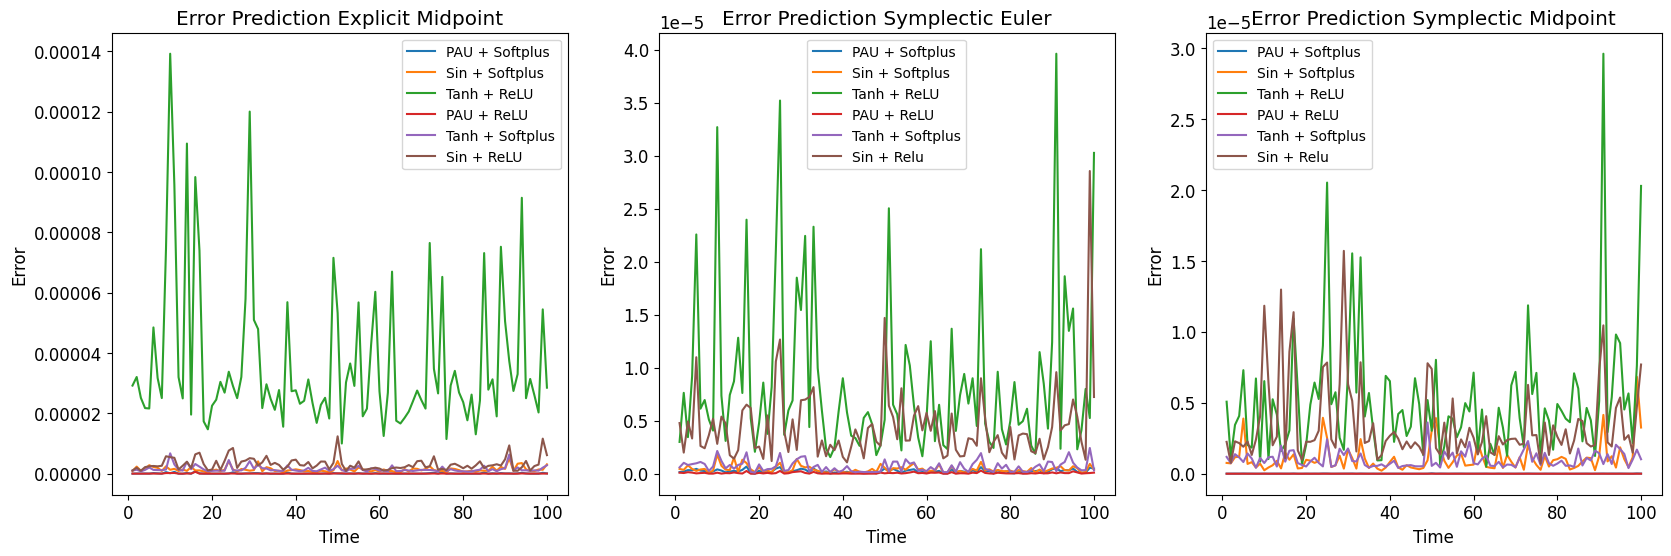

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

traject = np.linspace(1,ntraj_test,ntraj_test)

ax[0].plot(traject, err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(traject, err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].plot(traject, err_exp_Tanh_ReLU, label="Tanh + ReLU")
ax[0].plot(traject, err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].plot(traject, err_exp_Tanh_soft, label="Tanh + Softplus")
ax[0].plot(traject, err_exp_Sin_ReLU, label="Sin + ReLU")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Error")
ax[0].set_title("Error Prediction Explicit Midpoint")
ax[0].legend()


ax[1].plot(traject, err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(traject, err_symp_eul_Sin_Soft, label="Sin + Softplus")
ax[1].plot(traject, err_symp_eul_Tanh_ReLU, label="Tanh + ReLU")
ax[1].plot(traject, err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].plot(traject, err_symp_eul_Tanh_soft, label="Tanh + Softplus")
ax[1].plot(traject, err_symp_eul_Sin_ReLU, label="Sin + Relu")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Error")
ax[1].set_title("Error Prediction Symplectic Euler")
ax[1].legend()

ax[2].plot(traject, err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(traject, err_symp_Sin_Soft, label="Sin + Softplus")
ax[2].plot(traject, err_symp_Tanh_ReLU, label="Tanh + ReLU")
ax[2].plot(traject, err_symp_PAU_ReLU, label="PAU + ReLU")
ax[2].plot(traject, err_symp_Tanh_soft, label="Tanh + Softplus")
ax[2].plot(traject, err_symp_Sin_ReLU, label="Sin + Relu")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Error")
ax[2].set_title("Error Prediction Symplectic Midpoint")
ax[2].legend()


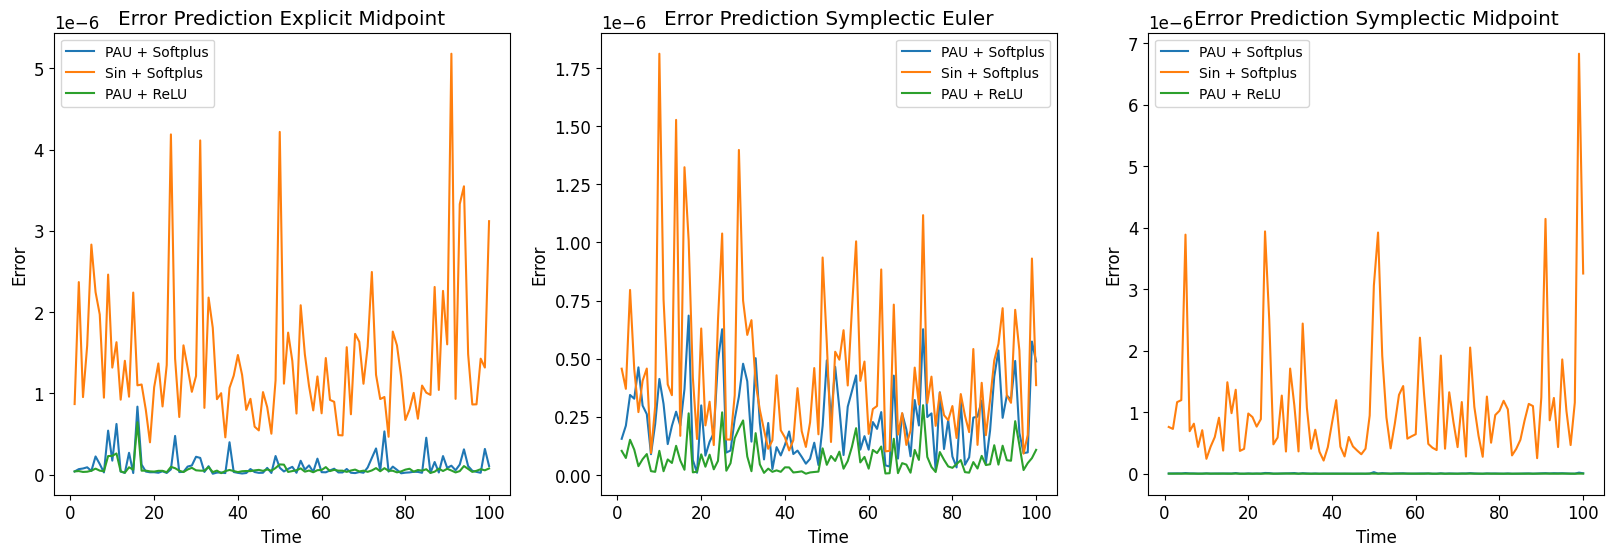

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

ax[0].plot(traject, err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(traject, err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].plot(traject, err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Error")
ax[0].set_title("Error Prediction Explicit Midpoint")
ax[0].legend()


ax[1].plot(traject, err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(traject, err_symp_eul_Sin_Soft, label="Sin + Softplus")
ax[1].plot(traject, err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Error")
ax[1].set_title("Error Prediction Symplectic Euler")
ax[1].legend()

ax[2].plot(traject, err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(traject, err_symp_Sin_Soft, label="Sin + Softplus")
ax[2].plot(traject, err_symp_PAU_ReLU, label="PAU + ReLU")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Error")
ax[2].set_title("Error Prediction Symplectic Midpoint")
ax[2].legend()


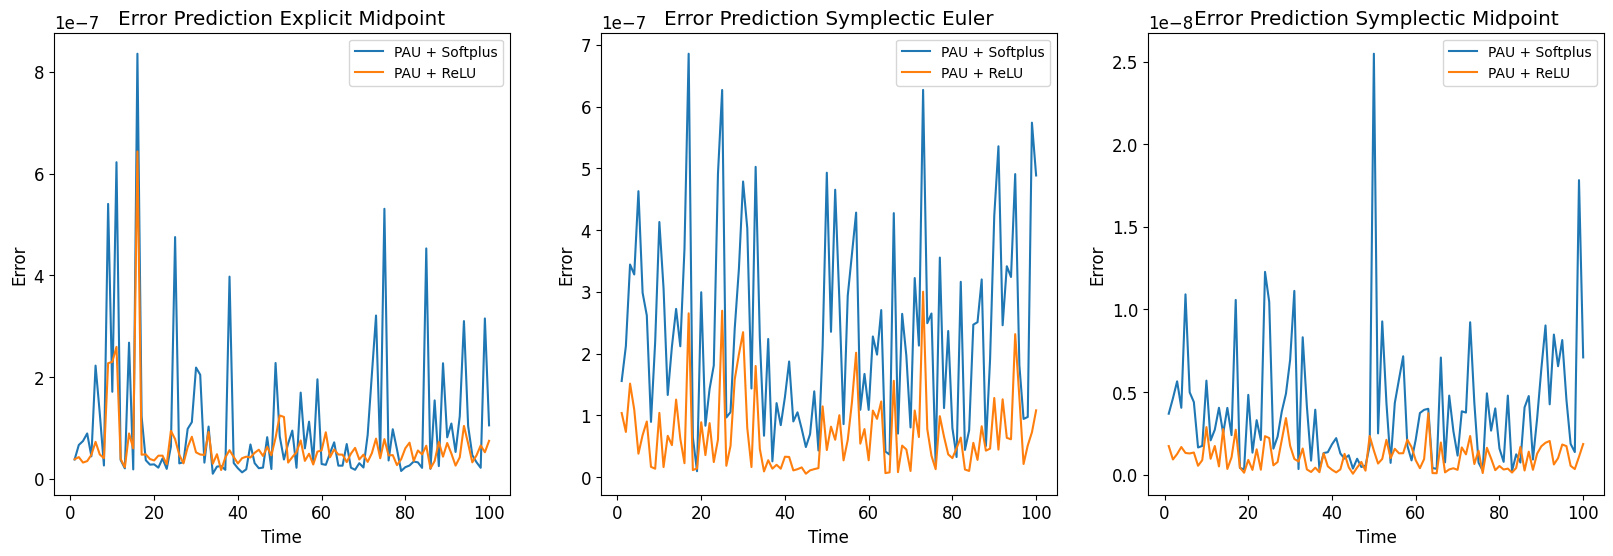

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

ax[0].plot(traject, err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(traject, err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Error")
ax[0].set_title("Error Prediction Explicit Midpoint")
ax[0].legend()


ax[1].plot(traject, err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(traject, err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Error")
ax[1].set_title("Error Prediction Symplectic Euler")
ax[1].legend()

ax[2].plot(traject, err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(traject, err_symp_PAU_ReLU, label="PAU + ReLU")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Error")
ax[2].set_title("Error Prediction Symplectic Midpoint")
ax[2].legend()

### Comparing prediction error in Hamiltonians

In [86]:
def get_Hamiltonians(u_exact, u_pred,sys,model):
    H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact])
    u_samples = u_pred

    #Computed estimated Hamiltonian from values for prediction
    H_model= torch.tensor([(model.Hamiltonian(u)- model.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
    #Computed true Hamiltonian values for prediction
    H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])
    #Computed NN Hamiltonian for exact
    H_model_exact = torch.tensor([(model.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact])

    return H_exact,H_model, H_exact_pred, H_model_exact


def test_loss(pred,exact):
    return ((pred-exact)**2).mean()

In [105]:
H_err_exp_PAU_Soft = []
H_err_exp_Sin_Soft = [] 
H_err_exp_Tanh_ReLU = []
H_err_exp_PAU_ReLU = []
H_err_exp_Tanh_soft = []
H_err_exp_Sin_ReLU = []

H_err_symp_eul_PAU_Soft = [] 
H_err_symp_eul_Sin_Soft = []
H_err_symp_eul_Tanh_ReLU = []
H_err_symp_eul_PAU_ReLU = []
H_err_symp_eul_Tanh_soft = []
H_err_symp_eul_Sin_ReLU = []

H_err_symp_PAU_Soft = [] 
H_err_symp_Sin_Soft = []
H_err_symp_Tanh_ReLU = []
H_err_symp_PAU_ReLU = []
H_err_symp_Tanh_soft = []
H_err_symp_Sin_ReLU = []

In [106]:
for i in range(u_symp_Sin_ReLU.shape[0]):
    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_eul[i],u_pred = u_symp_eul_PAU_Soft[i],sys = sys,model= model_symp_PAU_Soft)
    H_err_symp_eul_PAU_Soft.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_eul[i],u_pred = u_symp_eul_Sin_Soft[i],sys = sys,model= model_symp_eul_Sin_Soft)
    H_err_symp_eul_Sin_Soft.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_eul[i],u_pred = u_symp_eul_Tanh_ReLU[i],sys = sys,model= model_symp_eul_Tanh_ReLU)
    H_err_symp_eul_Tanh_ReLU.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_eul[i],u_pred = u_symp_eul_PAU_ReLU[i],sys = sys,model= model_symp_eul_PAU_ReLU)
    H_err_symp_eul_PAU_ReLU.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_eul[i],u_pred = u_symp_eul_Sin_ReLU[i],sys = sys,model= model_symp_eul_Sin_ReLU)
    H_err_symp_eul_Sin_ReLU.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_eul[i],u_pred = u_symp_eul_Tanh_soft[i],sys = sys,model= model_symp_eul_Tanh_soft)
    H_err_symp_eul_Tanh_soft.append(test_loss(H_model,H_exact))


    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp[i],u_pred = u_symp_PAU_Soft[i],sys = sys,model= model_symp_PAU_Soft)
    H_err_symp_PAU_Soft.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp[i],u_pred = u_symp_Sin_Soft[i],sys = sys,model= model_symp_Sin_Soft)
    H_err_symp_Sin_Soft.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp[i],u_pred = u_symp_Tanh_ReLU[i],sys = sys,model= model_symp_Tanh_ReLU)
    H_err_symp_Tanh_ReLU.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp[i],u_pred = u_symp_PAU_ReLU[i],sys = sys,model= model_symp_PAU_ReLU)
    H_err_symp_PAU_ReLU.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp[i],u_pred = u_symp_Sin_ReLU[i],sys = sys,model= model_symp_Sin_ReLU)
    H_err_symp_Sin_ReLU.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp[i],u_pred = u_symp_Tanh_soft[i],sys = sys,model= model_symp_Tanh_soft)
    H_err_symp_Tanh_soft.append(test_loss(H_model,H_exact))


    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp[i],u_pred = u_exp_PAU_Soft[i],sys = sys,model= model_exp_PAU_Soft)
    H_err_exp_PAU_Soft.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp[i],u_pred = u_exp_Sin_Soft[i],sys = sys,model= model_exp_Sin_Soft)
    H_err_exp_Sin_Soft.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp[i],u_pred = u_exp_Tanh_ReLU[i],sys = sys,model= model_exp_Tanh_ReLU)
    H_err_exp_Tanh_ReLU.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp[i],u_pred = u_exp_PAU_ReLU[i],sys = sys,model= model_exp_PAU_ReLU)
    H_err_exp_PAU_ReLU.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp[i],u_pred = u_exp_Sin_ReLU[i],sys = sys,model= model_exp_Sin_ReLU)
    H_err_exp_Sin_ReLU.append(test_loss(H_model,H_exact))

    H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp[i],u_pred = u_exp_Tanh_soft[i],sys = sys,model= model_exp_Tanh_soft)
    H_err_exp_Tanh_soft.append(test_loss(H_model,H_exact))




In [107]:
H_err_exp_PAU_Soft

[tensor(3.7398e-10, dtype=torch.float64),
 tensor(2.9779e-09, dtype=torch.float64),
 tensor(5.8825e-09, dtype=torch.float64),
 tensor(1.6300e-09, dtype=torch.float64),
 tensor(1.3804e-09, dtype=torch.float64),
 tensor(5.6844e-09, dtype=torch.float64),
 tensor(2.4883e-09, dtype=torch.float64),
 tensor(2.7637e-10, dtype=torch.float64),
 tensor(9.8937e-09, dtype=torch.float64),
 tensor(4.2932e-10, dtype=torch.float64),
 tensor(2.4094e-09, dtype=torch.float64),
 tensor(4.9014e-11, dtype=torch.float64),
 tensor(3.3103e-11, dtype=torch.float64),
 tensor(1.2365e-09, dtype=torch.float64),
 tensor(5.2040e-10, dtype=torch.float64),
 tensor(3.9531e-10, dtype=torch.float64),
 tensor(1.7545e-08, dtype=torch.float64),
 tensor(1.4056e-09, dtype=torch.float64),
 tensor(3.3139e-12, dtype=torch.float64),
 tensor(6.7523e-10, dtype=torch.float64),
 tensor(8.5085e-11, dtype=torch.float64),
 tensor(6.0696e-10, dtype=torch.float64),
 tensor(5.0645e-10, dtype=torch.float64),
 tensor(9.4606e-09, dtype=torch.fl

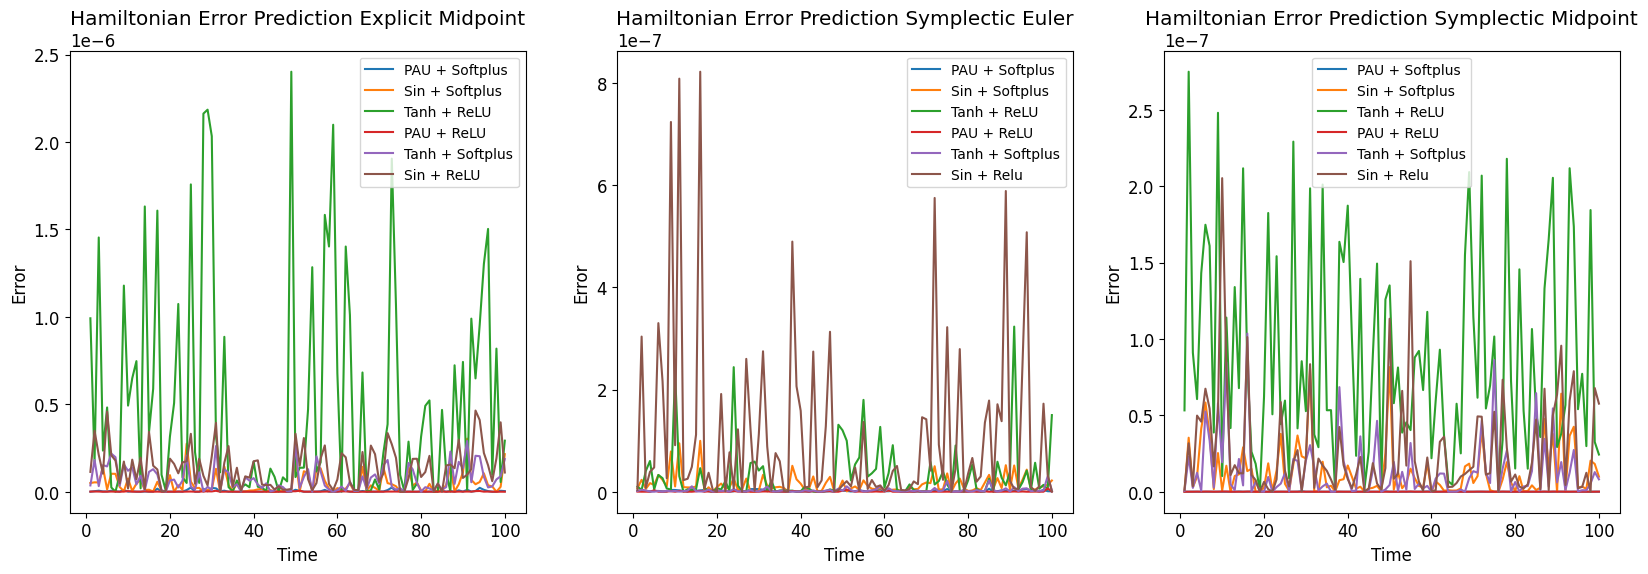

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

traject = np.linspace(1,ntraj_test,ntraj_test)


ax[0].plot(traject, H_err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(traject, H_err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].plot(traject, H_err_exp_Tanh_ReLU, label="Tanh + ReLU")
ax[0].plot(traject, H_err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].plot(traject, H_err_exp_Tanh_soft, label="Tanh + Softplus")
ax[0].plot(traject, H_err_exp_Sin_ReLU, label="Sin + ReLU")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Error")
ax[0].set_title("Hamiltonian Error Prediction Explicit Midpoint")
ax[0].legend()


ax[1].plot(traject, H_err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(traject, H_err_symp_eul_Sin_Soft, label="Sin + Softplus")
ax[1].plot(traject, H_err_symp_eul_Tanh_ReLU, label="Tanh + ReLU")
ax[1].plot(traject, H_err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].plot(traject, H_err_symp_eul_Tanh_soft, label="Tanh + Softplus")
ax[1].plot(traject, H_err_symp_eul_Sin_ReLU, label="Sin + Relu")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Error")
ax[1].set_title("Hamiltonian Error Prediction Symplectic Euler")
ax[1].legend()


ax[2].plot(traject, H_err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(traject, H_err_symp_Sin_Soft, label="Sin + Softplus")
ax[2].plot(traject, H_err_symp_Tanh_ReLU, label="Tanh + ReLU")
ax[2].plot(traject, H_err_symp_PAU_ReLU, label="PAU + ReLU")
ax[2].plot(traject, H_err_symp_Tanh_soft, label="Tanh + Softplus")
ax[2].plot(traject, H_err_symp_Sin_ReLU, label="Sin + Relu")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Error")
ax[2].set_title("Hamiltonian Error Prediction Symplectic Midpoint")
ax[2].legend()

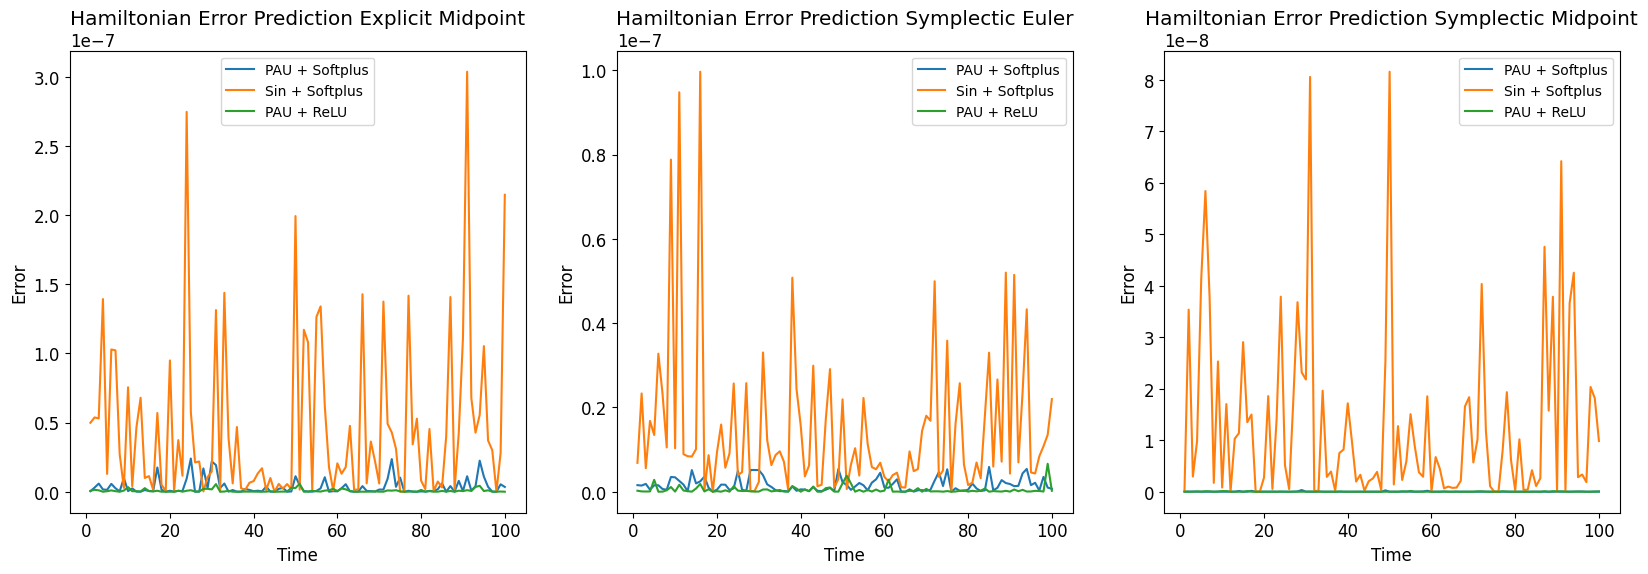

In [109]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

traject = np.linspace(1,ntraj_test,ntraj_test)


ax[0].plot(traject, H_err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(traject, H_err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].plot(traject, H_err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Error")
ax[0].set_title("Hamiltonian Error Prediction Explicit Midpoint")
ax[0].legend()


ax[1].plot(traject, H_err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(traject, H_err_symp_eul_Sin_Soft, label="Sin + Softplus")
ax[1].plot(traject, H_err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Error")
ax[1].set_title("Hamiltonian Error Prediction Symplectic Euler")
ax[1].legend()


ax[2].plot(traject, H_err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(traject, H_err_symp_Sin_Soft, label="Sin + Softplus")
ax[2].plot(traject, H_err_symp_PAU_ReLU, label="PAU + ReLU")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Error")
ax[2].set_title("Hamiltonian Error Prediction Symplectic Midpoint")
ax[2].legend()

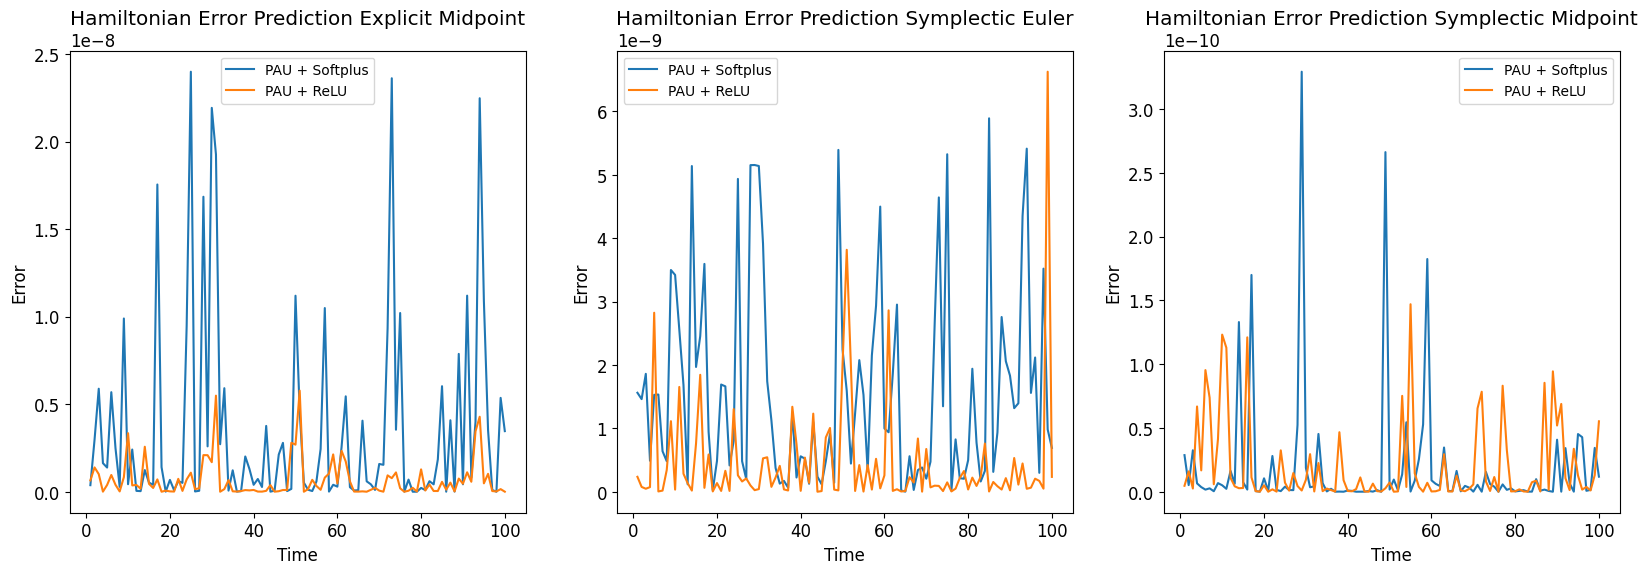

In [110]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

traject = np.linspace(1,ntraj_test,ntraj_test)


ax[0].plot(traject, H_err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(traject, H_err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Error")
ax[0].set_title("Hamiltonian Error Prediction Explicit Midpoint")
ax[0].legend()


ax[1].plot(traject, H_err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(traject, H_err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Error")
ax[1].set_title("Hamiltonian Error Prediction Symplectic Euler")
ax[1].legend()


ax[2].plot(traject, H_err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(traject, H_err_symp_PAU_ReLU, label="PAU + ReLU")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Error")
ax[2].set_title("Hamiltonian Error Prediction Symplectic Midpoint")
ax[2].legend()